In [449]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

In [450]:
dataframe = pd.read_csv('../../data/kalimati_tarkari_dataset.csv')
dataframe.set_index(pd.to_datetime(dataframe['Date']), inplace=True)
dataframe = dataframe[dataframe['Commodity'] == 'Sweet Orange']
dataframe = dataframe[['Minimum']]
dataframe

Minimum
Date               
2013-06-16     90.0
2013-06-17     90.0
2013-06-18     90.0
2013-06-19     90.0
2013-06-20     90.0
...             ...
2021-05-09    220.0
2021-05-10    220.0
2021-05-11    200.0
2021-05-12    200.0
2021-05-13    200.0

[2556 rows x 1 columns]

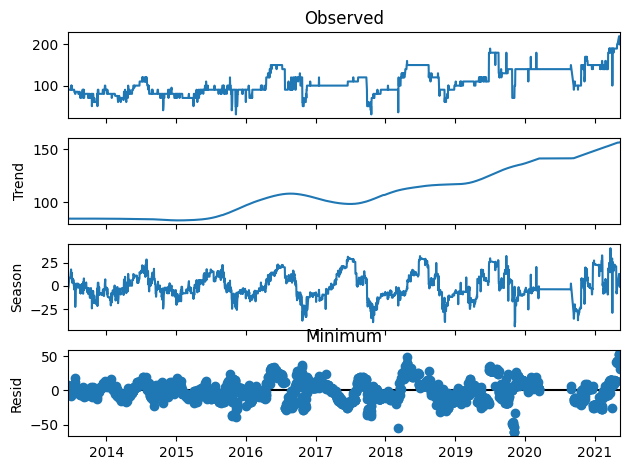

In [451]:
for column in dataframe.columns:
    if dataframe[column].dtype == 'object':
        continue
    res = STL(dataframe[[column]],period=365).fit()
    res.plot()
    plt.title(column)
    plt.show()

## Prophet

In [452]:
dataframe.reset_index(inplace=True)
dataframe.rename({'Date':'ds', 'Minimum':'y'}, axis='columns', inplace=True)
dataframe

ds      y
0    2013-06-16   90.0
1    2013-06-17   90.0
2    2013-06-18   90.0
3    2013-06-19   90.0
4    2013-06-20   90.0
...         ...    ...
2551 2021-05-09  220.0
2552 2021-05-10  220.0
2553 2021-05-11  200.0
2554 2021-05-12  200.0
2555 2021-05-13  200.0

[2556 rows x 2 columns]

In [453]:
m = Prophet()
m.fit(dataframe)

15:58:52 - cmdstanpy - INFO - Chain [1] start processing
15:58:52 - cmdstanpy - INFO - Chain [1] done processing


In [454]:
future = m.make_future_dataframe(periods=365)
future.tail()

ds
2916 2022-05-09
2917 2022-05-10
2918 2022-05-11
2919 2022-05-12
2920 2022-05-13

In [455]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds        yhat  yhat_lower  yhat_upper
2916 2022-05-09  208.174352  183.008992  231.311538
2917 2022-05-10  208.218014  185.281335  233.194363
2918 2022-05-11  208.669016  183.008463  232.484609
2919 2022-05-12  210.179438  186.068295  232.507051
2920 2022-05-13  210.196845  184.462158  232.987196

C:\Users\siera\PycharmProjects\road_map_datascience\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\siera\PycharmProjects\road_map_datascience\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



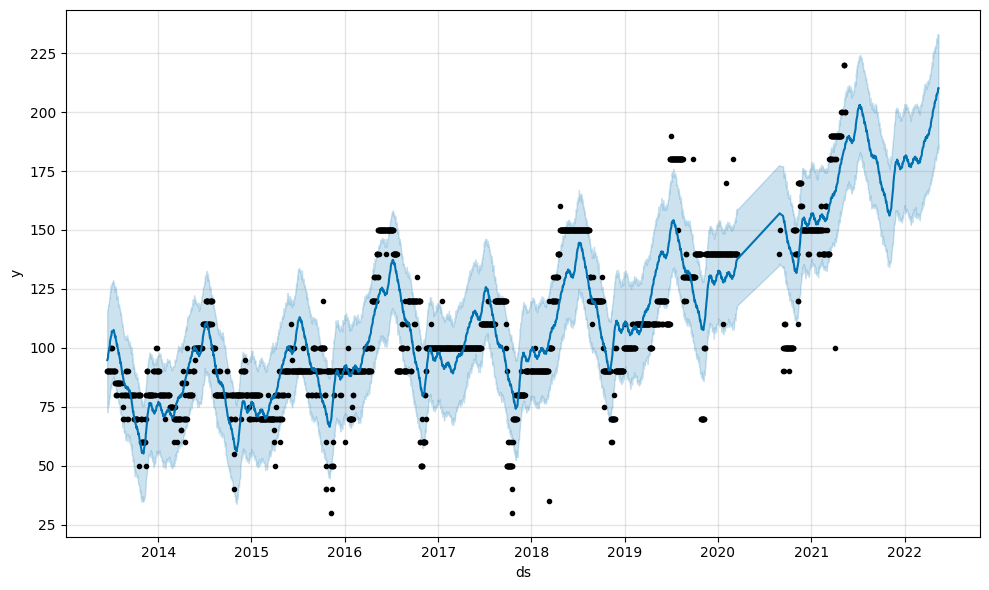

In [456]:
fig1 = m.plot(forecast)

C:\Users\siera\PycharmProjects\road_map_datascience\.venv\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\siera\PycharmProjects\road_map_datascience\.venv\Lib\site-packages\prophet\plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\siera\PycharmProjects\road_map_datascience\.venv\Lib\site-packages\prophet\plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.ar

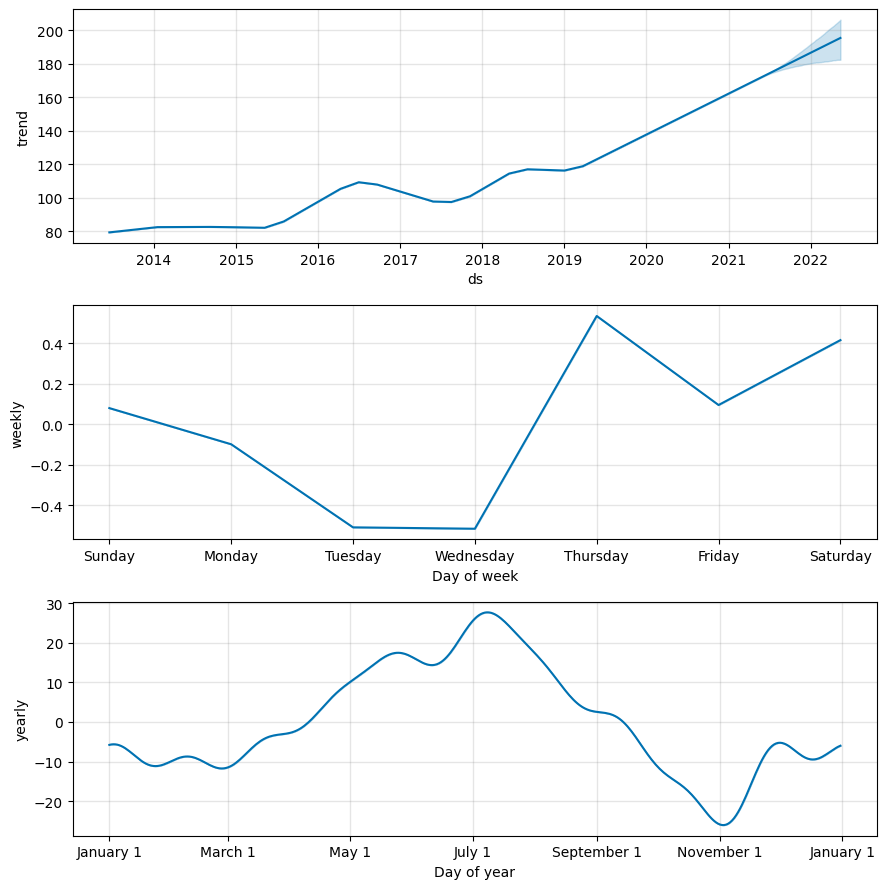

In [457]:
fig2 = m.plot_components(forecast)

In [458]:
plot_plotly(m, forecast)

In [459]:
plot_components_plotly(m, forecast)

In [460]:
data_real = dataframe[dataframe['ds'].isin(forecast['ds'])]
data_real['APE'] = abs((data_real['y'] - forecast['yhat'])) / data_real['y'] * 100
MAPE_s_hollyday = data_real['APE'].mean()

print(f'MAPE: {MAPE_s_hollyday:.2f}%')

MAPE: 12.64%


## Colocando a estaçãod e colheita Julho a Outubro

In [461]:
def is_harvest_season(ds):
    date = pd.to_datetime(ds)
    return (date.month > 4) or (date.month < 11)

dataframe['on_season'] = dataframe['ds'].apply(is_harvest_season)
dataframe['off_season'] = ~dataframe['ds'].apply(is_harvest_season)
dataframe

ds      y  on_season  off_season
0    2013-06-16   90.0       True       False
1    2013-06-17   90.0       True       False
2    2013-06-18   90.0       True       False
3    2013-06-19   90.0       True       False
4    2013-06-20   90.0       True       False
...         ...    ...        ...         ...
2551 2021-05-09  220.0       True       False
2552 2021-05-10  220.0       True       False
2553 2021-05-11  200.0       True       False
2554 2021-05-12  200.0       True       False
2555 2021-05-13  200.0       True       False

[2556 rows x 4 columns]

In [462]:
model = Prophet(weekly_seasonality=False,changepoint_prior_scale=0.12,seasonality_mode='multiplicative')
model.add_seasonality(name='weekly_on_season', period=7,fourier_order=2, condition_name='on_season',prior_scale=0.75)
model.add_seasonality(name='weekly_off_season', period=7,fourier_order=2, condition_name='off_season',prior_scale=0.05)


In [463]:
model.fit(dataframe)

15:58:54 - cmdstanpy - INFO - Chain [1] start processing
15:58:55 - cmdstanpy - INFO - Chain [1] done processing


In [464]:
future = model.make_future_dataframe(periods=365)  # Previsão para um ano à frente
future['on_season'] = future['ds'].apply(is_harvest_season)
future['off_season'] = ~future['ds'].apply(is_harvest_season)
forecast = model.predict(future)

C:\Users\siera\PycharmProjects\road_map_datascience\.venv\Lib\site-packages\prophet\plot.py:72: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\siera\PycharmProjects\road_map_datascience\.venv\Lib\site-packages\prophet\plot.py:73: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

C:\Users\siera\PycharmProjects\road_map_datascience\.venv\Lib\site-packages\prophet\plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.arra

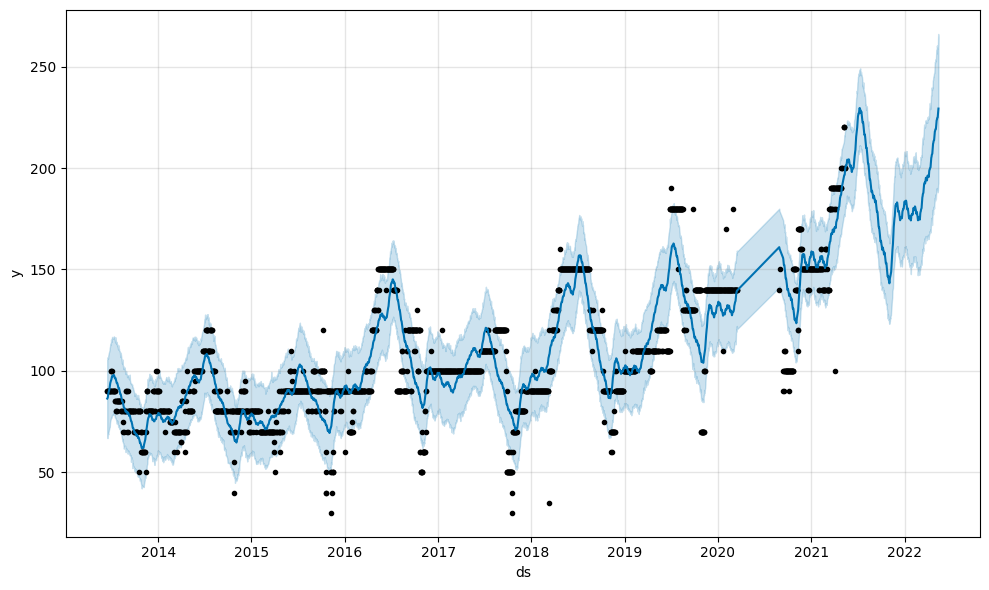

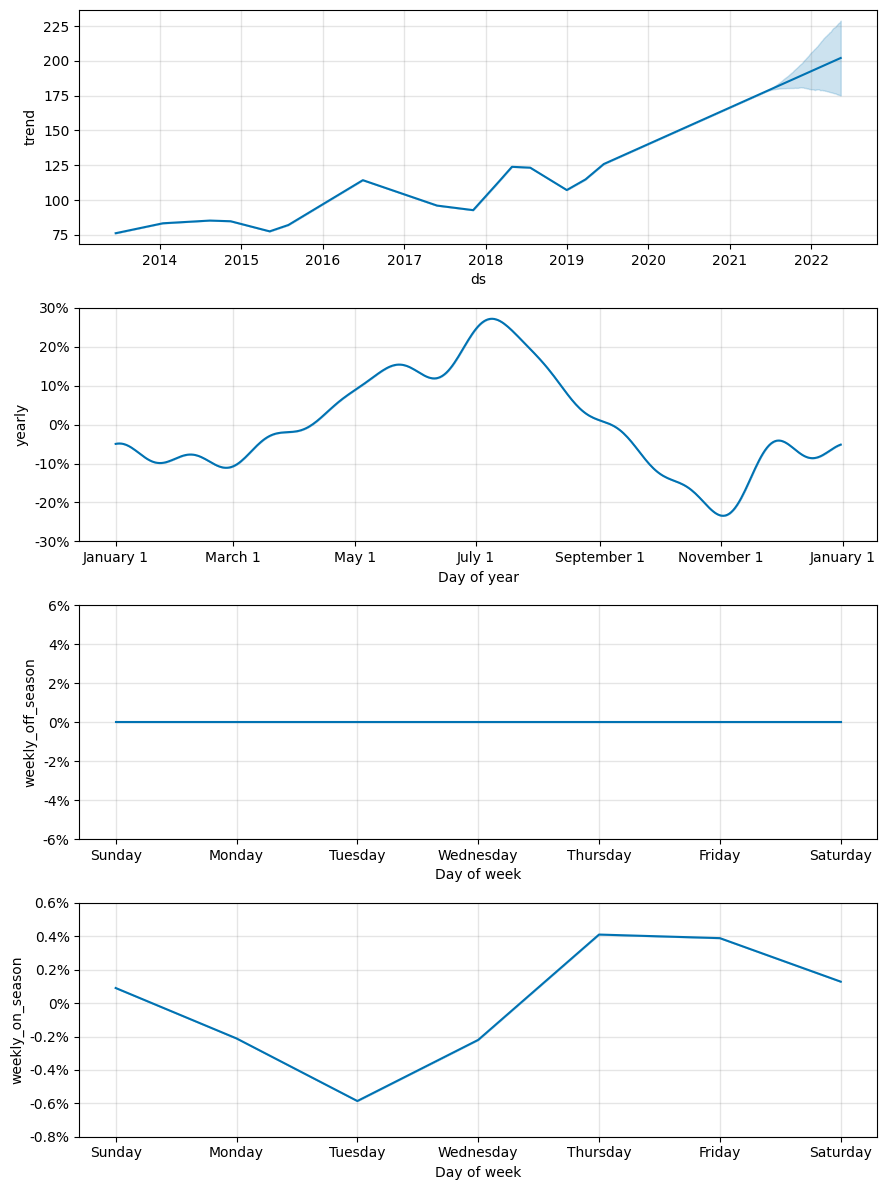

In [465]:
fig = model.plot(forecast)
fig2 = model.plot_components(forecast)

# Mostrar os gráficos
plt.show()

In [466]:
plot_plotly(model, forecast)

In [467]:
plot_components_plotly(model, forecast)

In [468]:
data_real = dataframe[dataframe['ds'].isin(forecast['ds'])]
data_real['APE'] = abs((data_real['y'] - forecast['yhat'])) / data_real['y'] * 100
MAPE_holly = data_real['APE'].mean()
print(f'MAPE: {MAPE_holly:.2f}%')

MAPE: 11.07%


In [469]:
print(f'MAPE: {MAPE_s_hollyday:.2f}%')

MAPE: 12.64%


## Interpretação final 
Com a adição da variavel exogena se é ou não epoca de colheita consegui melhora um pouco o MAPE da previsão MAS como existe um periodo sem dados, essa serie se torna uma serie complicada de prever e treinar.
Poderia ser adicionado valores no perido sem dados , mas esse não é o objetivo aqui.